In [1]:
import config
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import mysql.connector 
import requests
import json
from bs4 import BeautifulSoup
from mysql.connector import errorcode
import time
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm

cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = 'Shark'
)
cursor = cnx.cursor()

In [2]:
cursor.execute("""select * from Shark.RADNYC;""")
df = pd.DataFrame(cursor.fetchall())
df.head()

,0,1,2,3,4,5,6,7,8
0,1,NEW YORK CITY,1,97.0,2375.0,1322.0,393.0,199.0,APPROVED
1,2,NEW YORK CITY,1,98.0,2377.0,1325.0,389.0,203.0,APPROVED
2,3,NEW YORK CITY,1,102.0,2374.0,1328.0,388.0,203.0,APPROVED
3,4,NEW YORK CITY,1,93.0,2366.0,1323.0,393.0,201.0,APPROVED
4,5,NEW YORK CITY,1,95.0,2355.0,1332.0,394.0,207.0,APPROVED


In [3]:
df.columns = ['Index', "Location", "Month_Collected", "DER_nSv/h", "GAMMA_COUNT_R02", "GAMMA_COUNT_R03", "GAMMA_COUNT_R04", "GAMMA_COUNT_R05", "Status"]

# 1) Null hypothesis: Dose Eqivilant rate of Rochester ==  New York State Dose Eqivilant

    Alternative hypothesis : Rochester dose rate =! New York State Dose Eqiviant

In [4]:
# mu is population mean
# sigma is population std
# x is sample mean

mu = df['DER_nSv/h'].mean()
sigma = df['DER_nSv/h'].std()
x = df[df['Location'] == ' ROCHESTER'] ['DER_nSv/h'].sample(200, random_state = 2 ).mean()


mean: -0.0
standard deviation: 1.0


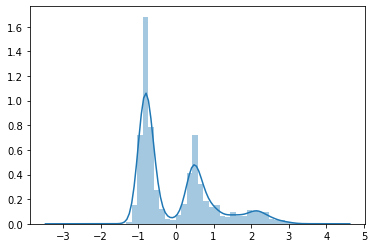

In [5]:
doe = df['DER_nSv/h'].values
standardized_doe = (doe - mu)/sigma

sns.distplot(standardized_doe, kde=True)

print("mean:", round(np.mean(standardized_doe)))
print("standard deviation:", round(np.std(standardized_doe)))

In [6]:
def calc_z_test (x, mu, sigma ):
    return (x - mu)/sigma

In [7]:
z = calc_z_test(x, mu, sigma)
z

0.5368852697913861

In [8]:
p = stats.norm.cdf(z)
p


0.7043265667488108

# 2) Null hypothesis: All Location have same amount of gammas in water
    Alternative hypothesis : All Location have different amount of gammas in water

([<matplotlib.axis.XTick at 0x1c2ce38dd8>,
 <a list of 5 Text xticklabel objects>)

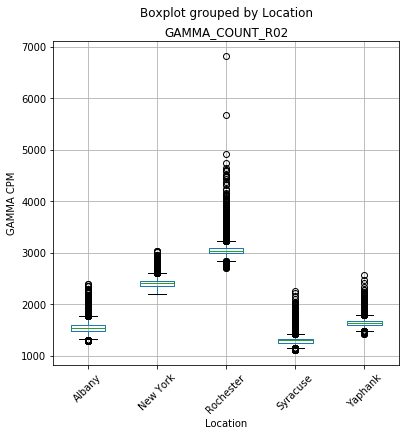

In [47]:
df.boxplot("GAMMA_COUNT_R02", by= "Location", figsize= (6,6))
plt.ylabel("GAMMA CPM")

plt.xticks([1, 2, 3, 4, 5 ] , ['Albany', "New York", "Rochester", "Syracuse", "Yaphank"], rotation=45)
# plt.set_xticklabels(df.index,rotation=90)

In [10]:
# why can we use ols in this case?
anova_location = ols('GAMMA_COUNT_R02 ~ Location ',data=df).fit()
anova_location.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        GAMMA_COUNT_R02   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 2.592e+05
Date:                Thu, 14 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:31:34   Log-Likelihood:            -1.7924e+05
No. Observations:               29138   AIC:                         3.585e+05
Df Residuals:                   29133   BIC:                         3.585e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1557.7228      1.462   1065.376      0.000    1554.857    1560.589
Location[T. NEW YORK CITY]   840.2261      2.131    394.242      0.000     836.049     844.403
Location[T. ROCHESTER]      1489.8259      1.978    753.031      0.000    1485.948    1493.704
Location[T. SYRACUSE]       -256.8766      2.091   -122.832      0.000    -260.976    -252.778
Location[T. YAPHANK]          79.7222      2.209     36.084      0.000      75.392      84.053
==============================================================================
Omnibus:                    30505.516   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7393786.346
Skew:                           4.784   Prob(JB):                         0.00
Kurtosis:                      80.450   Cond. No.                         5.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
anova_table = sm.stats.anova_lm(anova_location, type=2)
print(anova_table)

               df        sum_sq       mean_sq              F  PR(>F)
Location      4.0  1.337840e+10  3.344601e+09  259234.189507     0.0
Residual  29133.0  3.758696e+08  1.290185e+04            NaN     NaN


# 3) Null hypothesis: All months have same amount of gammas in water
    Alternative hypothesis : All months have different amount of gammas in water

Text(0, 0.5, 'Gamma CPM')

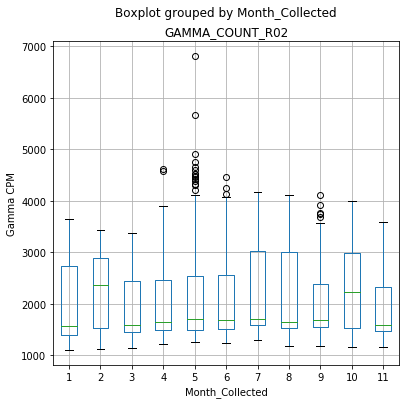

In [26]:
df.Month_Collected = df.Month_Collected.astype(int)
df.boxplot("GAMMA_COUNT_R02", by= "Month_Collected", figsize= (6,6))
plt.ylabel('Gamma CPM')

In [22]:
df.Month_Collected = df.Month_Collected.astype(str)
lm = ols('GAMMA_COUNT_R02 ~ Month_Collected', df).fit()
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        GAMMA_COUNT_R02   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     42.41
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           3.00e-84
Time:                        15:34:20   Log-Likelihood:            -2.3148e+05
No. Observations:               29138   AIC:                         4.630e+05
Df Residuals:                   29127   BIC:                         4.631e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1881.3753     12.695    148.198      0.000    1856.492    1906.258
Month_Collected[T.10]   249.1297     18.535     13.441      0.000     212.800     285.459
Month_Collected[T.11]    79.2274     23.411      3.384      0.001      33.341     125.114
Month_Collected[T.2]    288.5712     18.951     15.227      0.000     251.426     325.716
Month_Collected[T.3]     98.3489     17.259      5.699      0.000      64.521     132.176
Month_Collected[T.4]    161.7359     17.602      9.189      0.000     127.236     196.236
Month_Collected[T.5]    199.7962     17.617     11.341      0.000     165.267     234.325
Month_Collected[T.6]    198.6687     17.738     11.200      0.000     163.902     233.435
Month_Collected[T.7]    271.0256     18.833     14.391      0.000     234.111     307.940
Month_Collected[T.8]    120.1833     18.010      6.673      0.000      84.883     155.484
Month_Collected[T.9]    145.5290     19.311      7.536      0.000     107.678     183.380
==============================================================================
Omnibus:                    13925.765   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2693.772
Skew:                           0.496   Prob(JB):                         0.00
Kurtosis:                       1.890   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq       df          F        PR(>F)
Month_Collected  1.598646e+07      1.0  33.903907  5.850937e-09
Residual         1.373829e+10  29136.0        NaN           NaN
